In [23]:
from keras.preprocessing.image import img_to_array,load_img
from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b
from keras.applications import vgg16
from keras import backend as K
import numpy as np
import time
import matplotlib.pyplot as plt



In [24]:
#设置基础参数
base_image_path = 'image/content/tubingen.jpg'
style_reference_image_path = 'image/style/starry_night.jpg'
result_prefix = 'image/output_test/output'
iterations = 30
total_variation_weight = 8.5e-5
style_weight = 1.0
content_weight = 0.025

#设置产生图片的大小(将原来的图片进行等比缩放)
width, height = load_img(base_image_path).size

#行
img_nrows = 200
#列
img_ncols = int(width * img_nrows / height)


In [25]:
#图片的预处理

def preprocess_image(image_path):
    #使用keras内置函数读入图片并设置指定长度
    img = load_img(image_path,target_size=(img_nrows,img_ncols))
    #转为numpy 格式
    img = img_to_array(img)
    # Keras 中tensor是4维张量，所以给数据加上一个维度
    img = np.expand_dims(img,axis = 0)
    # vgg 提供的预处理，主要完成三个任务
    # 减去颜色均值 ： 可以提升效果
    # RGB转为BGR ：因为这个权重是在caffe上训练的，caffe的彩色维度顺序是BGR
    # 维度调换 ： 要根据系统设置的维度顺序 tensorflow 、theano 将通道维调到正确的位置，如theano的通道维应为第二维(batch,channel,width,height)
    img = vgg16.preprocess_input(img)
    return img


In [26]:
#反向操作,图片的逆操作
def depreprocess_image(x):
    x = x.reshape((img_nrows,img_ncols,3))
    #加上颜色均值
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.680
    
    #BGR -> RGB
    x = x[:,:,::-1]
    x = np.clip(x,0,255).astype(np.uint8)
    return x


In [27]:
# 设置Gram矩阵的计算图，首先用batch_flatten将输出的fearure map扁平化
# 然后自己跟自己的转置矩阵做乘法，跟我们之前说过的过程一样，注意这里的输入是深度学习网络某一层的输出值

def gram_matrix(x):
    # X的初始格式为 （14,14,512）  变换后 (512,14,14)，在做扁平化(512,14*14)
    # permute_dimensions 按照给定的模式重排一个张量
    # batch_flatten 将一个n阶张量转换为2阶张量，其第一维度保持不变
    # 这里的扁平化主要是保留特征图的个数，让二维的特征图编程一维（类似上图）
    features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    # 格拉姆矩阵
    gram = K.dot(features,K.transpose(features))
    
    return gram


# 设置风格Loss 的计算方式，以风格图片和待优化的图片的某一卷积层的输出作为输入
# 计算他们的Gram矩阵，然后计算两个Gram矩阵的差的平方，除以一个归一化的值(论文里介绍)

def style_loss(style,combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


#设置内容loss计算方式，以内容图片和待优化图片的representation为输入，计算他们差的平方，像素级对比

def content_loss(base, combination):
    return K.sum(K.square(base - combination))


#施加全变量正则，全变量正则化常用于图片的去噪，可以使生成的图片更加平滑自然

def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_nrows-1, :img_ncols-1, :] - x[:, 1:, :img_ncols-1, :])
    b = K.square(x[:, :img_nrows-1, :img_ncols-1, :] - x[:, :img_nrows-1, 1:, :])
    
    return K.sum(K.pow(a+b,1.25))



In [28]:
# 读入内容和风格图，包装为Keras张量，这是一个4维张量

base_image = K.variable(preprocess_image(base_image_path))# 内容图
style_reference_image = K.variable(preprocess_image(style_reference_image_path))# 风格图

#初始化一个待优化图片的占位符，就是噪声图片或内容图片

combination_image = K.placeholder((1,img_nrows,img_ncols,3))

#将三个张量串联到一起，形成一个形状为（3，img_nrows, img_ncols, 3）的张量

input_tensor = K.concatenate([base_image,style_reference_image,combination_image],axis = 0)

In [29]:
#载入模型
model = vgg16.VGG16(input_tensor=input_tensor,weights='imagenet',include_top=False)
print('Model Loaded')

#这是一个字典，建立了层名称到层输出张量的映射，通过这个字典我们可以通过层的名字来获取层的张量
# 使用model.get_layer(layer_name).output的效果也是一样

output_dict = dict([(layer.name, layer.output) for layer in model.layers])

#初始化loss值
loss = K.variable(0.)

# 计算内容损失取内容图像和待优化图像即可
# 这里只读取一层的输出进行对比，取多层输出效果变化不大
# Layer_features 就是图片在模型的block5_conv2这层的输出了，记得我们把输入做成了(3,n_row,n_col,3)的张量
# 0号位置对应内容图像的输出，1号位置是风格图像的，，2号位置是待优化图像的
layer_features = output_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

# 计算内容损失
loss += content_weight * content_loss(base_image_features,combination_features)

# 计算风格损失
# 与上面的过程类似，只是对多个层的输出作用而已，求出多个层的风格loss，相加求平均即可

feature_layers = ['block1_conv1','block2_conv1',
                  'block3_conv1','block4_conv1',
                  'block5_conv1']

for layer_name in feature_layers:
    layer_features = output_dict[layer_name]
    style_reference_features  = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    #计算风格损失
    s_l = style_loss(style_reference_features,combination_features)
    loss += (style_weight/len(feature_layers)) * s_l
    
    
# 求全变量正则，加入loss
loss = loss + total_variation_weight * total_variation_loss(combination_image)


Model Loaded


In [30]:
# 得到loss函数关于combination_image的梯度
grads = K.gradients(loss,combination_image)

outputs = [loss]

#同时得到梯度和损失，所以这两个都应该是计算图的输出
#0 号位是loss，1号位是grads
outputs += grads

# 编译计算图，前面是声明计算关系

f_outputs = K.function([combination_image],outputs)

In [35]:
#获取loss和grads

def eval_loss_and_grads(x):
    #把输入reshape层矩阵
    x = x.reshape((1,img_nrows,img_ncols,3))
    #调用计算图
    outs = f_outputs([x])
    loss_value = outs[0]
    #outs 是一个长为2的tuple，0号位是loss，1号位是grads，把grads扁平化
    grad_values = outs[1].flatten().astype('float64')
    
    return loss_value,grad_values

In [37]:
#定义两个方法，一个用于返回loss，一个用于返回grads

class Evaluator(object):
    def __init__(self):
        #初始化损失值和梯度
        self.loss_value = None
        self.grads_value = None
        
    def loss(self,x):
        #使用函数得到提渎职和损失值，但只返回损失值，梯度值保存
        assert self.loss_value is None
        loss_value,grads_value = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_value = grads_value
        return self.loss_value
    
    def grads(self,x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grad_values

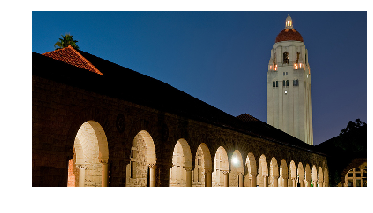

start of iteration 0
Current loss value: 2702673200.0
Image saved as  image/output_test/output_at_itteration_0.png
Iteration 0 completed in 199s


d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


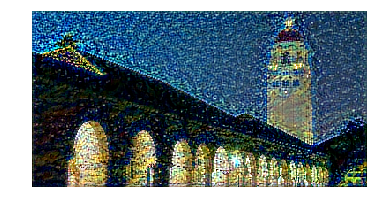

start of iteration 1
Current loss value: 544746800.0
Image saved as  image/output_test/output_at_itteration_1.png
Iteration 1 completed in 208s


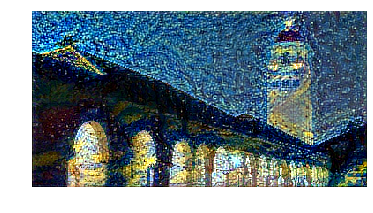

start of iteration 2
Current loss value: 234801470.0
Image saved as  image/output_test/output_at_itteration_2.png
Iteration 2 completed in 198s


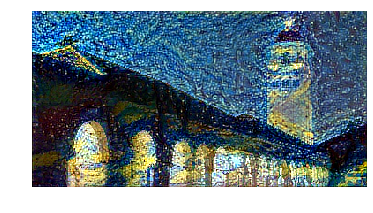

start of iteration 3
Current loss value: 156065760.0
Image saved as  image/output_test/output_at_itteration_3.png
Iteration 3 completed in 166s


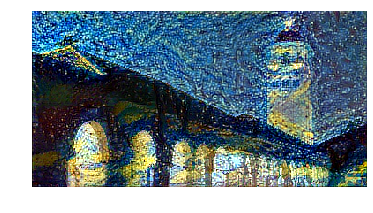

start of iteration 4
Current loss value: 115551460.0
Image saved as  image/output_test/output_at_itteration_4.png
Iteration 4 completed in 172s


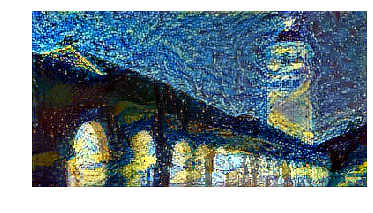

start of iteration 5
Current loss value: 90000240.0
Image saved as  image/output_test/output_at_itteration_5.png
Iteration 5 completed in 194s


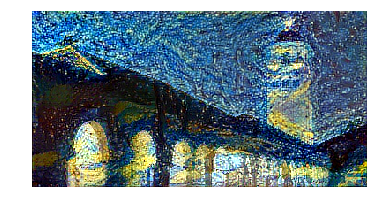

start of iteration 6
Current loss value: 77334330.0
Image saved as  image/output_test/output_at_itteration_6.png
Iteration 6 completed in 196s


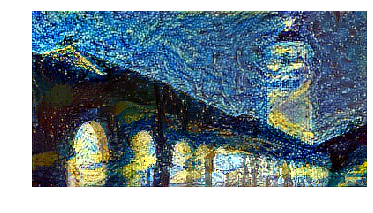

start of iteration 7
Current loss value: 67987704.0
Image saved as  image/output_test/output_at_itteration_7.png
Iteration 7 completed in 197s


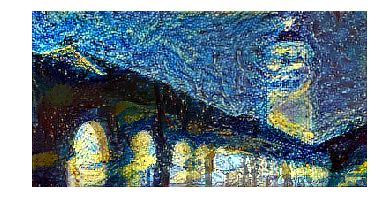

start of iteration 8
Current loss value: 61483510.0
Image saved as  image/output_test/output_at_itteration_8.png
Iteration 8 completed in 196s


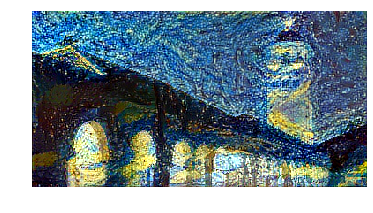

start of iteration 9
Current loss value: 56967492.0
Image saved as  image/output_test/output_at_itteration_9.png
Iteration 9 completed in 191s


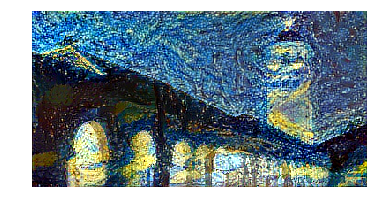

start of iteration 10
Current loss value: 53641336.0
Image saved as  image/output_test/output_at_itteration_10.png
Iteration 10 completed in 168s


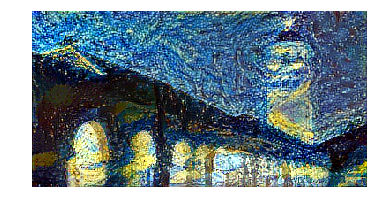

start of iteration 11
Current loss value: 49791490.0
Image saved as  image/output_test/output_at_itteration_11.png
Iteration 11 completed in 168s


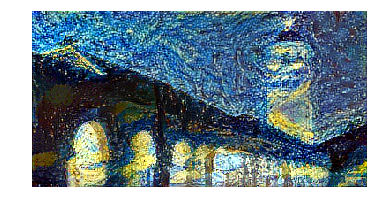

start of iteration 12
Current loss value: 46823028.0
Image saved as  image/output_test/output_at_itteration_12.png
Iteration 12 completed in 170s


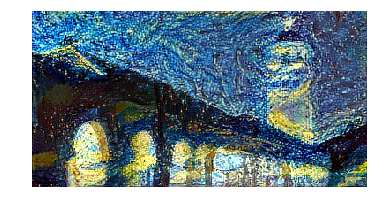

start of iteration 13
Current loss value: 44108972.0
Image saved as  image/output_test/output_at_itteration_13.png
Iteration 13 completed in 168s


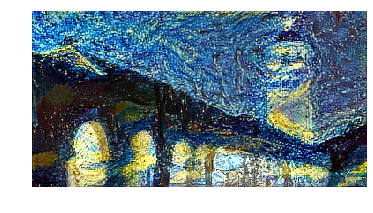

start of iteration 14
Current loss value: 41892580.0
Image saved as  image/output_test/output_at_itteration_14.png
Iteration 14 completed in 170s


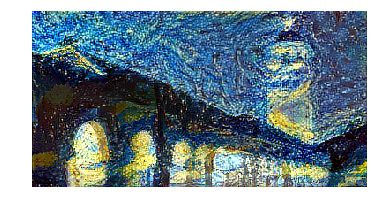

start of iteration 15
Current loss value: 40036764.0
Image saved as  image/output_test/output_at_itteration_15.png
Iteration 15 completed in 168s


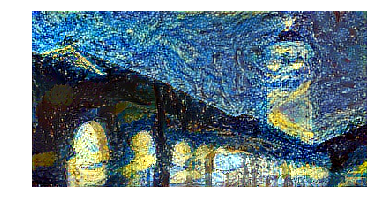

start of iteration 16
Current loss value: 38688652.0
Image saved as  image/output_test/output_at_itteration_16.png
Iteration 16 completed in 170s


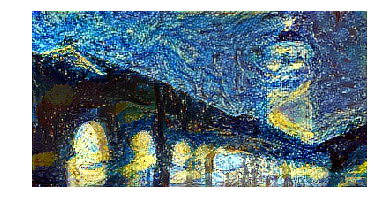

start of iteration 17
Current loss value: 37164750.0
Image saved as  image/output_test/output_at_itteration_17.png
Iteration 17 completed in 169s


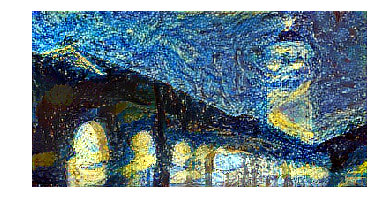

start of iteration 18
Current loss value: 36108628.0
Image saved as  image/output_test/output_at_itteration_18.png
Iteration 18 completed in 170s


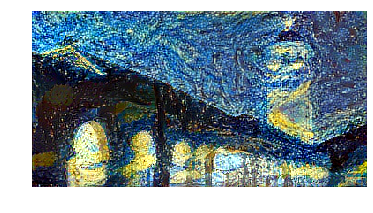

start of iteration 19
Current loss value: 34704500.0
Image saved as  image/output_test/output_at_itteration_19.png
Iteration 19 completed in 184s


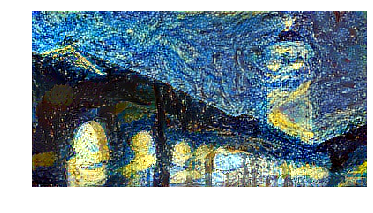

start of iteration 20
Current loss value: 33444074.0
Image saved as  image/output_test/output_at_itteration_20.png
Iteration 20 completed in 171s


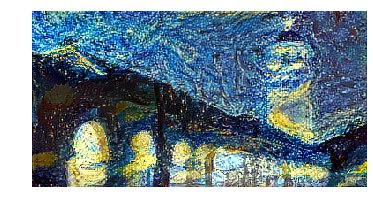

start of iteration 21
Current loss value: 32513450.0
Image saved as  image/output_test/output_at_itteration_21.png
Iteration 21 completed in 170s


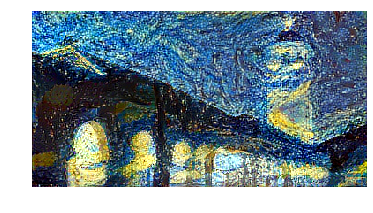

start of iteration 22
Current loss value: 31670522.0
Image saved as  image/output_test/output_at_itteration_22.png
Iteration 22 completed in 169s


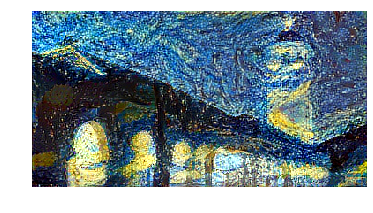

start of iteration 23
Current loss value: 30970656.0
Image saved as  image/output_test/output_at_itteration_23.png
Iteration 23 completed in 169s


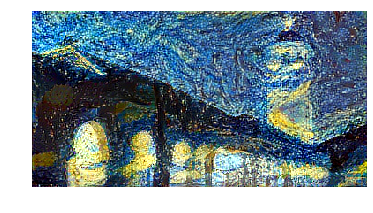

start of iteration 24
Current loss value: 30403592.0
Image saved as  image/output_test/output_at_itteration_24.png
Iteration 24 completed in 168s


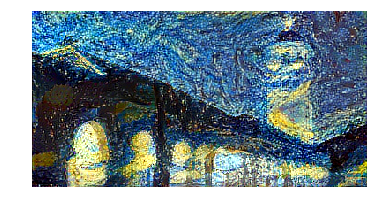

start of iteration 25
Current loss value: 29888518.0
Image saved as  image/output_test/output_at_itteration_25.png
Iteration 25 completed in 168s


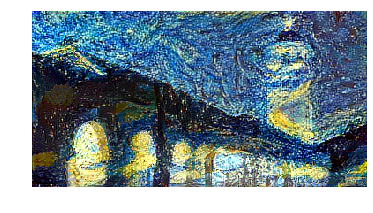

start of iteration 26
Current loss value: 29403168.0
Image saved as  image/output_test/output_at_itteration_26.png
Iteration 26 completed in 170s


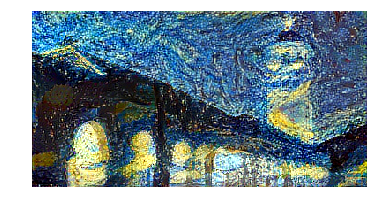

start of iteration 27
Current loss value: 28935468.0
Image saved as  image/output_test/output_at_itteration_27.png
Iteration 27 completed in 168s


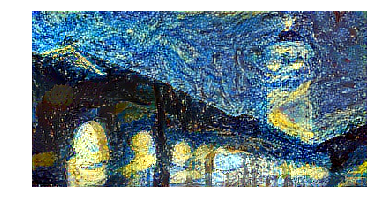

start of iteration 28
Current loss value: 28498414.0
Image saved as  image/output_test/output_at_itteration_28.png
Iteration 28 completed in 168s


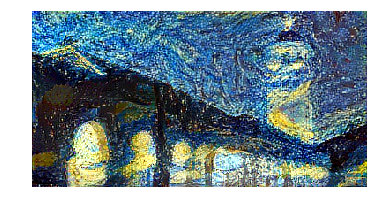

start of iteration 29
Current loss value: 27996316.0
Image saved as  image/output_test/output_at_itteration_29.png
Iteration 29 completed in 167s


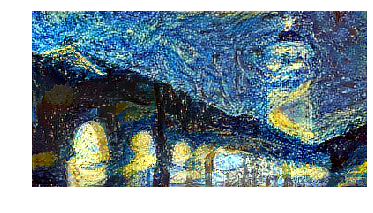

In [38]:
evaluator = Evaluator()

#使用内容图片作为待优化图片
x = preprocess_image(base_image_path)

#显示原始图片
img = load_img(base_image_path,target_size=(img_nrows,img_ncols))
plt.imshow(img)
plt.axis('off')
plt.show()

for i in range(iterations):
    print('start of iteration',i)
    start_time = time.time()
    # 使用L-BFGS(论文中提出牛顿法) 算法来最小化loss
    # 参数1 ： 传入一个带返回值的函数，然后最小化返回值
    # 参数2 ： 初始值（初始图片）
    # 参数3 ： 传入一个带返回值的函数，返回值是梯度
    # 参数4 ： 迭代次数
    # 返回值1 ：优化后的值(改变的图片)
    # 返回值2 ： loss 值
    # 返回值3 ： 计算过程的一些信息
    x,min_loss,info = fmin_l_bfgs_b(evaluator.loss,x.flatten(),fprime=evaluator.grads,maxfun=20)
    
    print('Current loss value:',min_loss)
    
    #反向操作
    img = depreprocess_image(x.copy())
    
    #保存图片
    fname = result_prefix + '_at_itteration_%d.png' % i
    print('Image saved as ',fname)
    imsave(fname,img)
    
    end_time = time.time()
    print('Iteration %d completed in %ds'%(i,end_time - start_time))
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()